In [9]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
import scipy.io
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
events_raw = scipy.io.loadmat(path + "/data/stripes.mat")
events_rel = events_raw["events"]
events = np.zeros(events_rel.shape)
events[:,0] = events_rel[:,3] * 10e-6
events[:,1:] = events_rel[:,:3]

events_raw = events

In [11]:
events_ref = flt.filter_refract(events_raw, 0.5)

In [12]:
start_time = 0.5
duration = 0.5
events_t = flt.filter_time(events_ref, start_time, start_time+duration)
events_t.shape

(6881, 4)

In [13]:
patch_center = (64, 64)
patch_size = 128
shape = (patch_size, patch_size)
events = flt.filter_patch(events_t, patch_center, patch_size)
events.shape

(6723, 4)

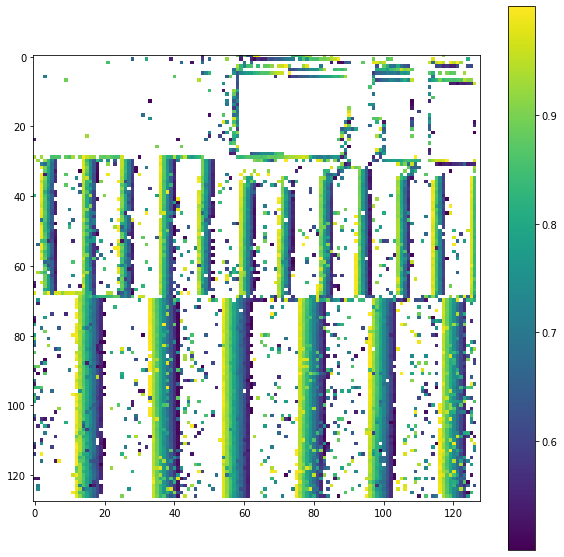

In [14]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, shape, filter_polarity=False)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
plt.colorbar(mappable=m)

In [21]:
last_time = np.full(shape, -1.0)
dist = 2
td_predictions = {}
predictions = {}
px_range_pred = 5
event_sign = np.full(shape, -1)

angles = []

U = np.zeros(shape)
V = np.zeros(shape)
ofs = np.zeros(shape)

final_td = np.zeros(shape)

for e in tqdm(events):
    x = int(e[1])
    y = int(e[2])
    
#     if e[3] == 0:
#         continue
    
    last_sign = event_sign[y, x]
    last_time[y, x] = e[0]
    event_sign[y, x] = e[3]
    
    u_td = (e[0] - last_time[y-dist, x] 
            if y-dist >= 0 and last_time[y-dist, x] != -1.0 and event_sign[y-dist, x] == e[3]
            else float("Nan"))
    d_td = (e[0] - last_time[y+dist, x] 
            if y+dist<shape[0] and last_time[y+dist, x] != -1.0 and event_sign[y+dist, x] == e[3]
            else float("Nan"))
    r_td = (e[0] - last_time[y, x+dist] 
            if x+dist < shape[1] and last_time[y, x+dist] != -1.0 and event_sign[y, x+dist] == e[3]
            else float("Nan"))
    l_td = (e[0] - last_time[y, x-dist] 
            if x-dist >= 0 and last_time[y, x-dist] != -1.0 and event_sign[y, x-dist] == e[3]
            else float("Nan"))
    
    #get camera direction
#     id_direction = np.searchsorted(gt[:,0], e[0])
# #     print(id_direction)
#     direction = directions[id_direction] - np.pi
#     direction = np.mod(direction, 2*np.pi)
    direction = np.pi
    #     print(np.rad2deg(direction))
    
    if 0.0 <= direction < np.pi/2:
        v_td = d_td
        h_td = l_td
    elif np.pi/2 <= direction < np.pi:
        v_td = d_td
        h_td = -r_td
    elif np.pi <= direction < (3/2)*np.pi:
        v_td = -u_td
        h_td = -r_td
    elif (3/2)*np.pi <= direction < 2*np.pi:
        v_td = -u_td
#         h_td = l_td
    
#     v_td = -u_td if not np.isnan(u_td) else d_td
#     h_td = -r_td if not np.isnan(r_td) else l_td

    h_td = h_td if not np.isnan(h_td) else 0
    v_td = v_td if not np.isnan(v_td) else 0

#     U[y, x] = h_td #if not np.isnan(h_td) else 0
#     V[y, x] = v_td #if not np.isnan(v_td) else 0
    
#     if np.isnan(v_td) or np.isnan(h_td):
#         continue
    
    
    m = np.sqrt(np.square(v_td) + np.square(h_td))
    a = direction - np.arctan2(v_td, h_td)
    
    angles.append(a)
    
    of = m * np.cos(a)
    ofs[y, x] = of
    time_difference = of / dist
    
    U[y, x] = np.cos(direction) * time_difference
    V[y, x] = np.sin(direction) * time_difference
    
    if (y, x) in td_predictions:
        mean_pred = np.mean(td_predictions[y, x])
        std_pred = np.std(td_predictions[y, x])
        
        if 0.1 > np.abs(mean_pred - time_difference) > 20*std_pred:
            last_time[y, x] = -1.0
            event_sign[y, x] = last_sign
            continue
        if np.abs(mean_pred - time_difference) > 0.1:
            td_predictions[y, x] = []
            predictions[y, x] = []
            continue
        if e[0] > start_time + duration -0.12 and len(td_predictions[y, x]) > 10:
            final_td[y, x] = mean_pred
            
    td_predictions[y, x] = []
    a = direction
    
    for i in range(1, px_range_pred +1):
        for k in range(-int(px_range_pred / 2), int(px_range_pred / 2)):
            x_p = int(x + np.cos(a)*i + np.sin(a)*k)
            y_p = int(y + np.sin(a)*i - np.cos(a)*k)
            
            pred_time = last_time[y, x] + time_difference * i

            if x_p < 0 or x_p >= shape[1] or y_p < 0 or y_p >= shape[0]:
                continue
            
            if (y_p, x_p) in predictions:
                predictions[y_p, x_p].append(pred_time)
                td_predictions[y_p, x_p].append(time_difference)
            else:
                predictions[y_p, x_p] = [pred_time]
                td_predictions[y_p, x_p] = [time_difference]

100%|████████████████████████████████████████████████████████████████████████████| 6723/6723 [00:01<00:00, 6216.00it/s]


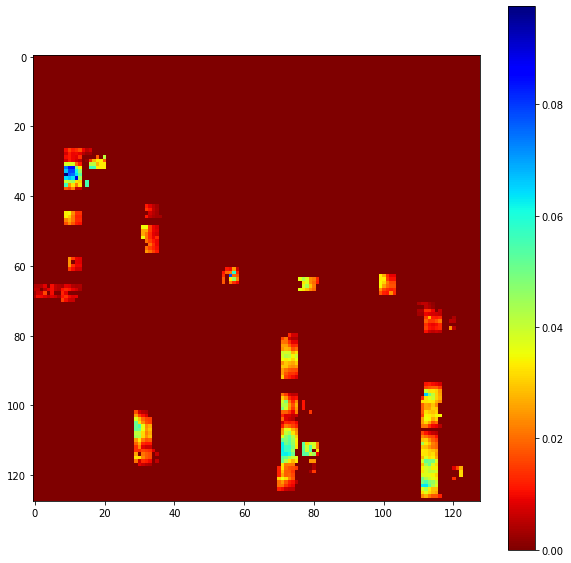

In [22]:
%matplotlib inline
img, count = td.mean_from_dict(td_predictions, shape, 3)

plt.figure(figsize=(10, 10))
m = plt.imshow(img, cmap="jet_r")
plt.colorbar(m)

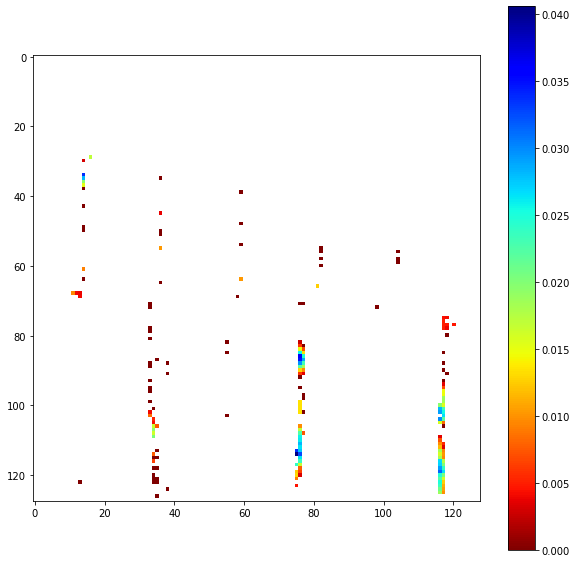

In [23]:
plt.figure(figsize=(10, 10))
final_td_m = np.ma.masked_where(final_td == 0, final_td)
m = plt.imshow(final_td_m, cmap="jet_r", interpolation="none")
plt.colorbar(m)